In [ ]:
import tensorflow as tf
import os
from PIL import Image
import shutil
import random

import matplotlib.pyplot as plt

In [ ]:
url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"

file_path = tf.keras.utils.get_file("images.tar.gz", url, extract=True)

dataset_dir = "/root/.keras/datasets/images"


791918971/791918971 [==============================] - 32s 0us/step


/root/.keras/datasets/images


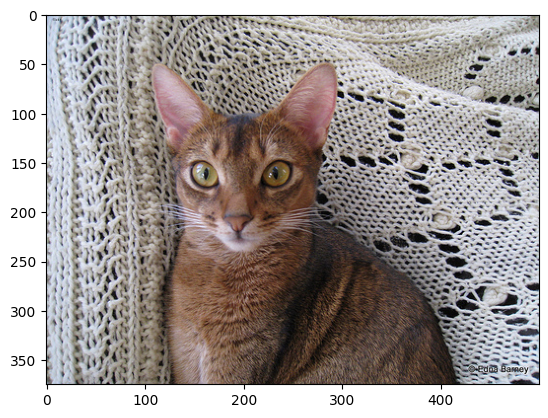

In [ ]:
img = Image.open(os.path.join(dataset_dir,"Abyssinian_77.jpg"))
assert img is not None
plt.imshow(img)
img.show()
print(dataset_dir)

In [ ]:
basedir = dataset_dir

allfiles = os.listdir(basedir)

In [ ]:
def get_classname_from_filename(filename):
    chunks = filename.split('_')[:-1]
    classname = "_".join(chunks)
    return classname.lower()

#test
get_classname_from_filename("AMERICAN_bulldog_3748.jpg")


'american_bulldog'

In [ ]:
categories = set()
for filename in allfiles:
    categories.add(get_classname_from_filename(filename))

print(categories)
print("found {} categories".format(len(categories)))

{'ragdoll', 'birman', 'persian', 'boxer', 'maine_coon', 'american_pit_bull_terrier', 'sphynx', 'siamese', 'abyssinian', 'staffordshire_bull_terrier', 'bombay', 'pug', 'keeshond', 'bengal', 'leonberger', 'samoyed', 'chihuahua', 'american_bulldog', 'german_shorthaired', 'english_cocker_spaniel', 'miniature_pinscher', 'beagle', 'yorkshire_terrier', 'basset_hound', 'scottish_terrier', 'pomeranian', 'british_shorthair', 'shiba_inu', 'newfoundland', 'egyptian_mau', 'saint_bernard', 'great_pyrenees', 'japanese_chin', 'russian_blue', 'havanese', 'english_setter', 'wheaten_terrier'}
found 37 categories


In [ ]:
categorized_dir = os.path.join(basedir,'CAT')
for category in categories:
    os.makedirs(os.path.join(categorized_dir,category))

In [ ]:
for filename in allfiles:
    filepath  = os.path.join(basedir,filename)
    classname = get_classname_from_filename(filename)
    classpath = os.path.join(categorized_dir,classname)
    shutil.move(filepath,classpath)

In [ ]:
#divide to train:test = 1:1

traindir = os.path.join(categorized_dir,"split","train")
testdir  = os.path.join(categorized_dir,"split","test")

for category in categories:
    allfiles = os.listdir(os.path.join(categorized_dir,category))
    random.shuffle(allfiles)
    midpoint = len(allfiles)//2
    trainset = allfiles[:midpoint]
    testset =  allfiles[midpoint:]

    trainsubdir = os.path.join(traindir,category)
    os.makedirs(trainsubdir)
    for file in trainset:
        filepath = os.path.join(categorized_dir,category,file)
        shutil.move(filepath,trainsubdir)

    testsubdir = os.path.join(testdir,category)
    os.makedirs(testsubdir)
    for file in testset:
        filepath = os.path.join(categorized_dir,category,file)
        shutil.move(filepath,testsubdir)

In [ ]:
# define dir paths, after moving teh split dir to a better loc.

splitdir = r'''/root/.keras/datasets/images/CAT/split'''
traindir = os.path.join(splitdir,"train")
testdir = os.path.join(splitdir,"test")


In [ ]:
batch_size = 32
image_size = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(traindir,
                                                            shuffle=True,
                                                            subset="training",
                                                            validation_split = 0.2,
                                                            batch_size=batch_size,
                                                            image_size=image_size,
                                                            seed=42)

val_dataset = tf.keras.utils.image_dataset_from_directory(traindir,
                                                            shuffle=True,
                                                            subset="validation",
                                                            validation_split = 0.2,
                                                            batch_size=batch_size,
                                                            image_size=image_size,
                                                            seed=42)

Found 3693 files belonging to 37 classes.
Using 2955 files for training.
Found 3693 files belonging to 37 classes.
Using 738 files for validation.


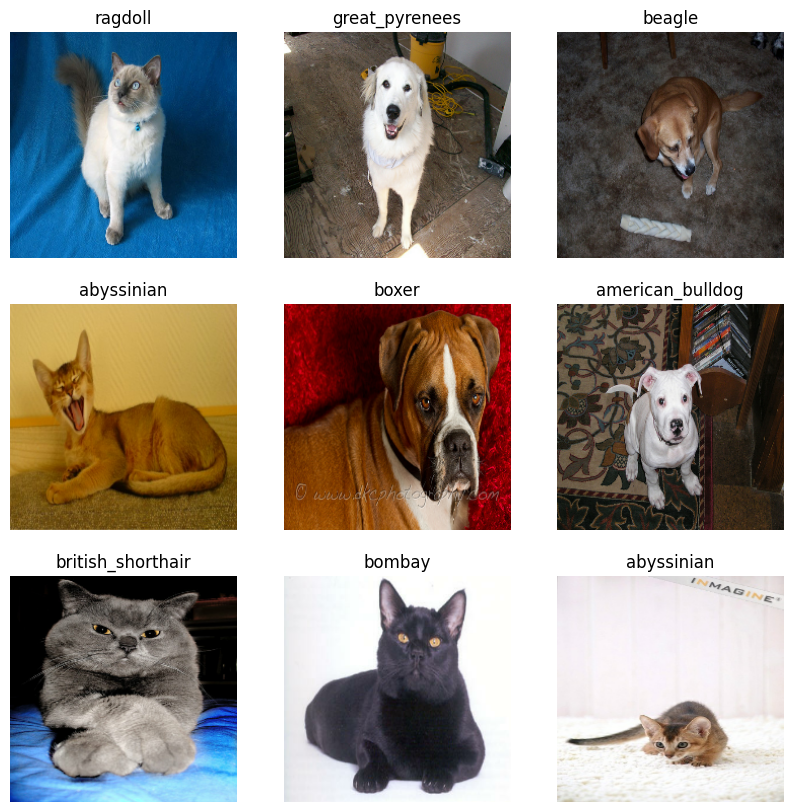

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validatioval_datasetn_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

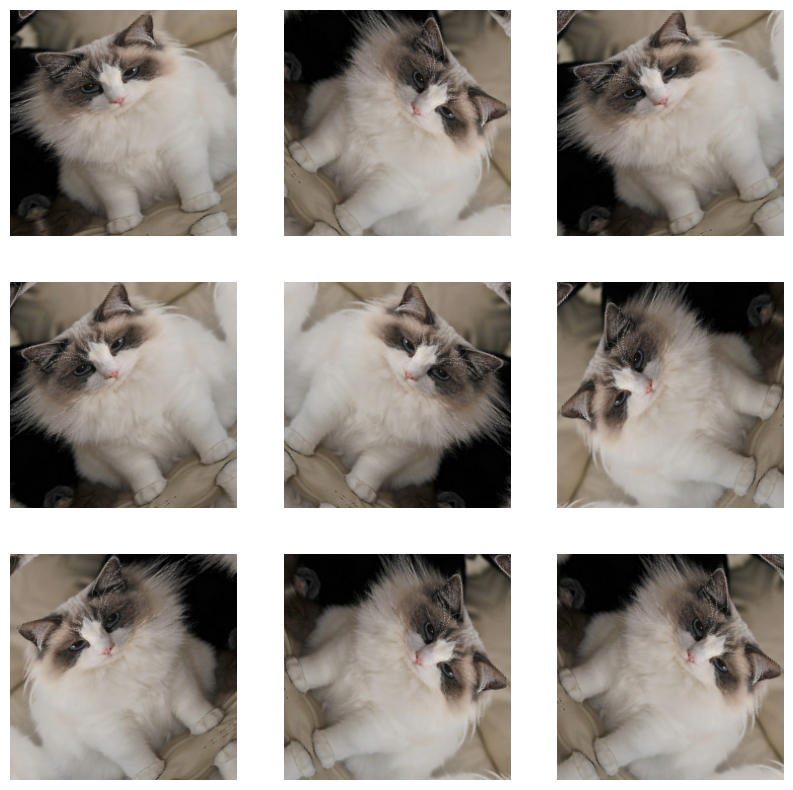

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [ ]:
# Create the base model from the pre-trained model ResNet50
IMG_SHAPE = image_size + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                      include_top=False,
                      weights='imagenet')

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
num_labels = 37

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_labels, activation='softmax')

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

In [ ]:
len(model.trainable_variables)

2

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
initial_epochs = 15

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset,
                    verbose=1)

Epoch 1/15
93/93 [==============================] - 27s 162ms/step - loss: 3.4369 - accuracy: 0.1120 - val_loss: 2.7475 - val_accuracy: 0.2602
Epoch 2/15
93/93 [==============================] - 14s 145ms/step - loss: 2.4252 - accuracy: 0.3675 - val_loss: 1.9572 - val_accuracy: 0.5081
Epoch 3/15
93/93 [==============================] - 14s 146ms/step - loss: 1.8333 - accuracy: 0.5479 - val_loss: 1.4758 - val_accuracy: 0.6450
Epoch 4/15
93/93 [==============================] - 14s 150ms/step - loss: 1.4427 - accuracy: 0.6555 - val_loss: 1.1741 - val_accuracy: 0.7249
Epoch 5/15
93/93 [==============================] - 17s 173ms/step - loss: 1.1886 - accuracy: 0.7154 - val_loss: 0.9781 - val_accuracy: 0.7737
Epoch 6/15
93/93 [==============================] - 14s 150ms/step - loss: 1.0052 - accuracy: 0.7611 - val_loss: 0.8400 - val_accuracy: 0.8035
Epoch 7/15
93/93 [==============================] - 14s 150ms/step - loss: 0.8864 - accuracy: 0.7895 - val_loss: 0.7467 - val_accuracy: 0.8347

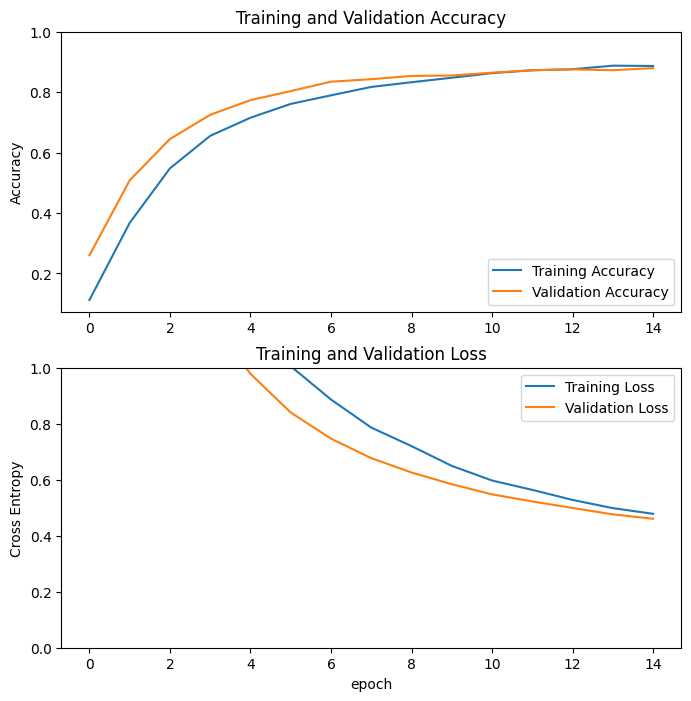

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss0, accuracy0 = model.evaluate(val_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

24/24 [==============================] - 3s 95ms/step - loss: 0.4604 - accuracy: 0.8794
initial loss: 0.46
initial accuracy: 0.88


In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 125

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

In [ ]:
len(model.trainable_variables)

62

In [ ]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset)

Epoch 15/30
93/93 [==============================] - 35s 228ms/step - loss: 0.3310 - accuracy: 0.8931 - val_loss: 0.3360 - val_accuracy: 0.8875
Epoch 16/30
93/93 [==============================] - 19s 200ms/step - loss: 0.2420 - accuracy: 0.9184 - val_loss: 0.3221 - val_accuracy: 0.8902
Epoch 17/30
93/93 [==============================] - 20s 209ms/step - loss: 0.1973 - accuracy: 0.9374 - val_loss: 0.3419 - val_accuracy: 0.8821
Epoch 18/30
93/93 [==============================] - 19s 198ms/step - loss: 0.1588 - accuracy: 0.9492 - val_loss: 0.3311 - val_accuracy: 0.8970
Epoch 19/30
93/93 [==============================] - 21s 223ms/step - loss: 0.1240 - accuracy: 0.9611 - val_loss: 0.3160 - val_accuracy: 0.9024
Epoch 20/30
93/93 [==============================] - 19s 197ms/step - loss: 0.0947 - accuracy: 0.9723 - val_loss: 0.3610 - val_accuracy: 0.8943
Epoch 21/30
93/93 [==============================] - 21s 225ms/step - loss: 0.0889 - accuracy: 0.9695 - val_loss: 0.3283 - val_accuracy:

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

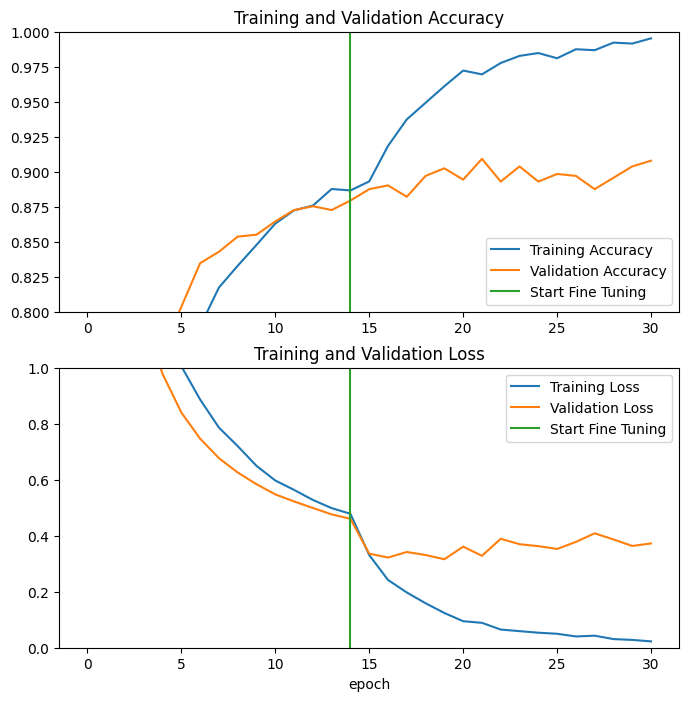

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
test_dataset = tf.keras.utils.image_dataset_from_directory(testdir,
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=image_size,
                                                            seed=42)

Found 3697 files belonging to 37 classes.


In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

116/116 [==============================] - 14s 113ms/step - loss: 0.3530 - accuracy: 0.9086
Test accuracy : 0.9085745215415955
